In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
#from sklearn.pipeline import make_pipeline
from scipy.optimize import linprog
from scipy.optimize import dual_annealing
from pulp import LpMaximize, LpProblem, LpStatus, lpSum, LpVariable

In [ ]:
#https://www.kaggle.com/code/rukenmissonnier/master-polynomial-regression-with-this-notebook

In [3]:
df = pd.read_csv("./data/manufacturing.csv")

,Temperature (°C),Pressure (kPa),Temperature x Pressure,Material Fusion Metric,Material Transformation Metric,Quality Rating
count,3957.000000,3957.000000,3957.000000,3957.000000,3.957000e+03,3957.000000
mean,200.034704,14.815558,2955.321308,48127.183128,1.003645e+07,96.260179
std,58.135717,5.772040,1458.224940,23812.213513,7.599356e+06,12.992262
min,100.014490,5.003008,513.706875,10156.971955,9.999462e+05,1.000000
25%,150.871296,9.692984,1798.247303,27626.929091,3.433810e+06,99.941129
50%,198.603371,14.832557,2678.277782,44611.452164,7.833390e+06,99.999997
75%,251.366552,19.749680,3929.058261,67805.443846,1.588251e+07,100.000000
max,299.992804,24.999132,7365.018714,103756.181544,2.699783e+07,100.000000


In [ ]:
#initial data checks: all numerical? response variable clear?

In [4]:
#summary stats
df.describe()

,Temperature (°C),Pressure (kPa),Temperature x Pressure,Material Fusion Metric,Material Transformation Metric,Quality Rating
count,3957.000000,3957.000000,3957.000000,3957.000000,3.957000e+03,3957.000000
mean,200.034704,14.815558,2955.321308,48127.183128,1.003645e+07,96.260179
std,58.135717,5.772040,1458.224940,23812.213513,7.599356e+06,12.992262
min,100.014490,5.003008,513.706875,10156.971955,9.999462e+05,1.000000
25%,150.871296,9.692984,1798.247303,27626.929091,3.433810e+06,99.941129
50%,198.603371,14.832557,2678.277782,44611.452164,7.833390e+06,99.999997
75%,251.366552,19.749680,3929.058261,67805.443846,1.588251e+07,100.000000
max,299.992804,24.999132,7365.018714,103756.181544,2.699783e+07,100.000000


In [ ]:
#missing data?
df.isnull().sum()

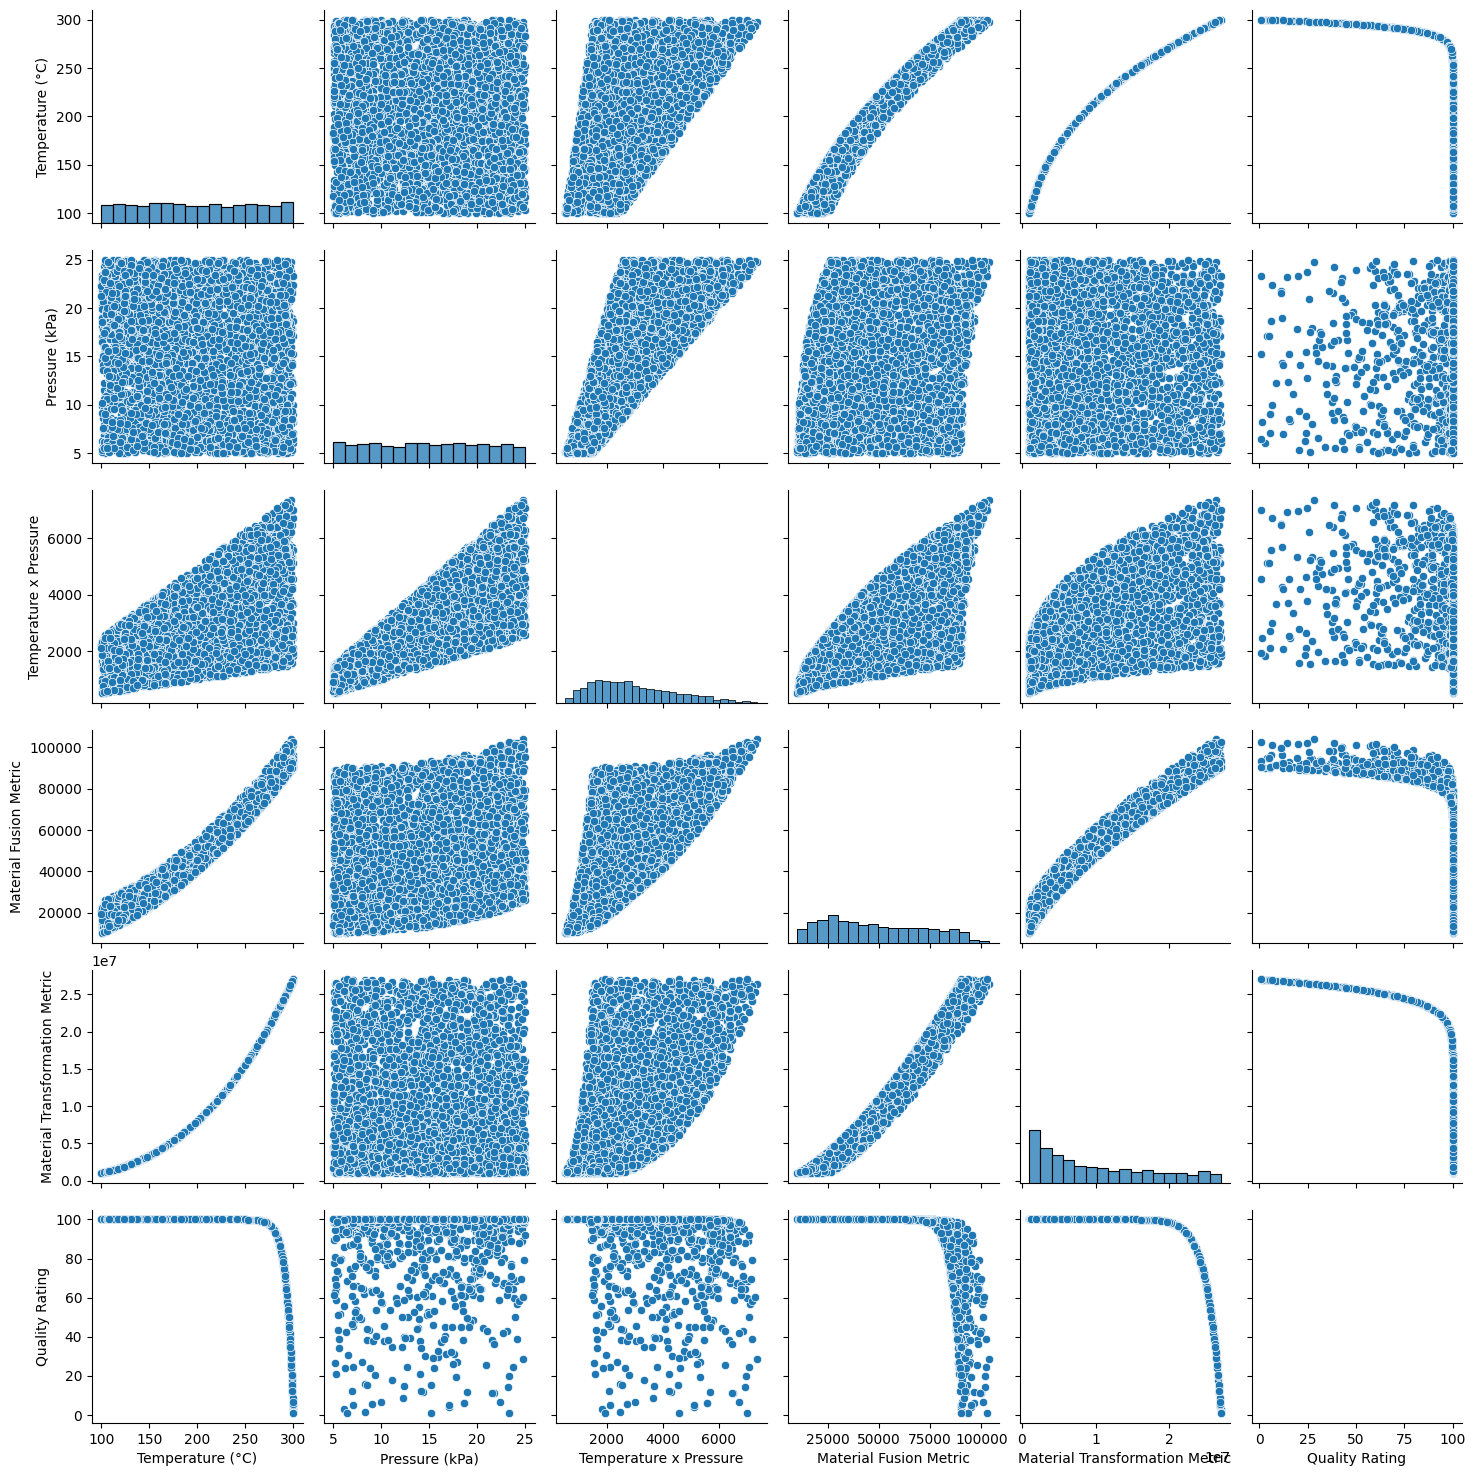

In [7]:
#pairplots
#get non-response cols assuming arg "response" is valid col name
#cols = [el for el in list(df.columns) if el!=response]
sns.pairplot(df, vars=['Temperature (°C)', 'Pressure (kPa)', 'Temperature x Pressure',
                      'Material Fusion Metric', 'Material Transformation Metric', 'Quality Rating'])
plt.show()

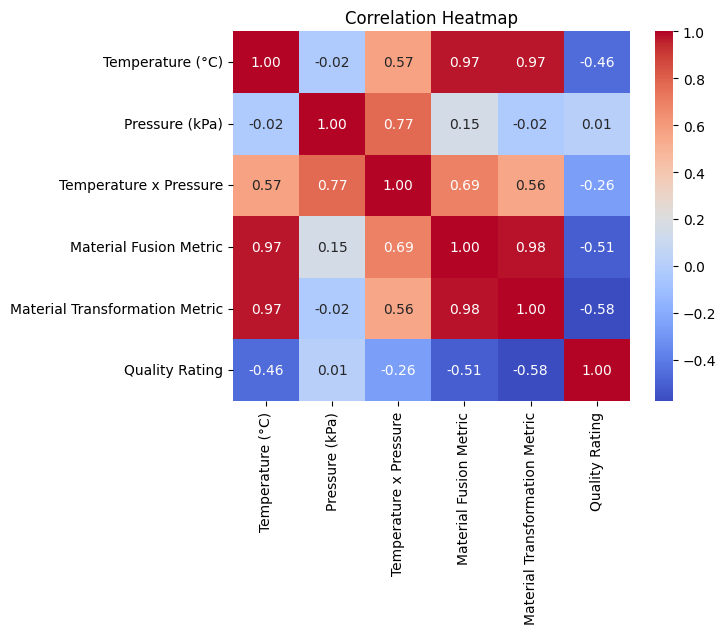

In [9]:
#correlation heatmap
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

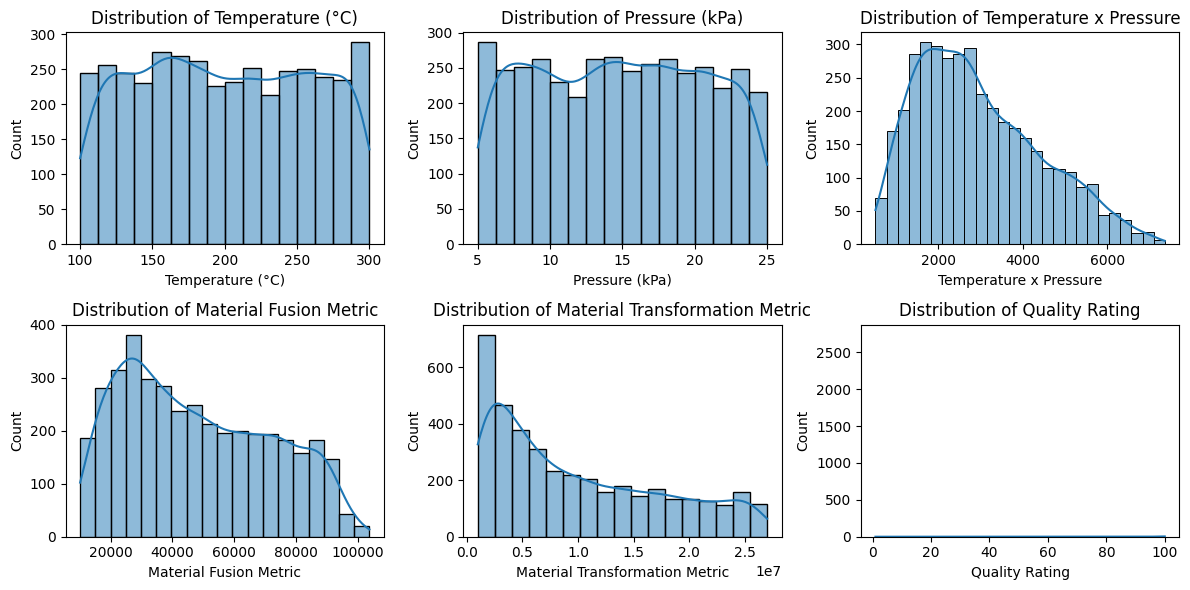

In [10]:
#distribution plots
plt.figure(figsize=(12, 6))
numerical_columns = df.columns
for i, col in enumerate(numerical_columns):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

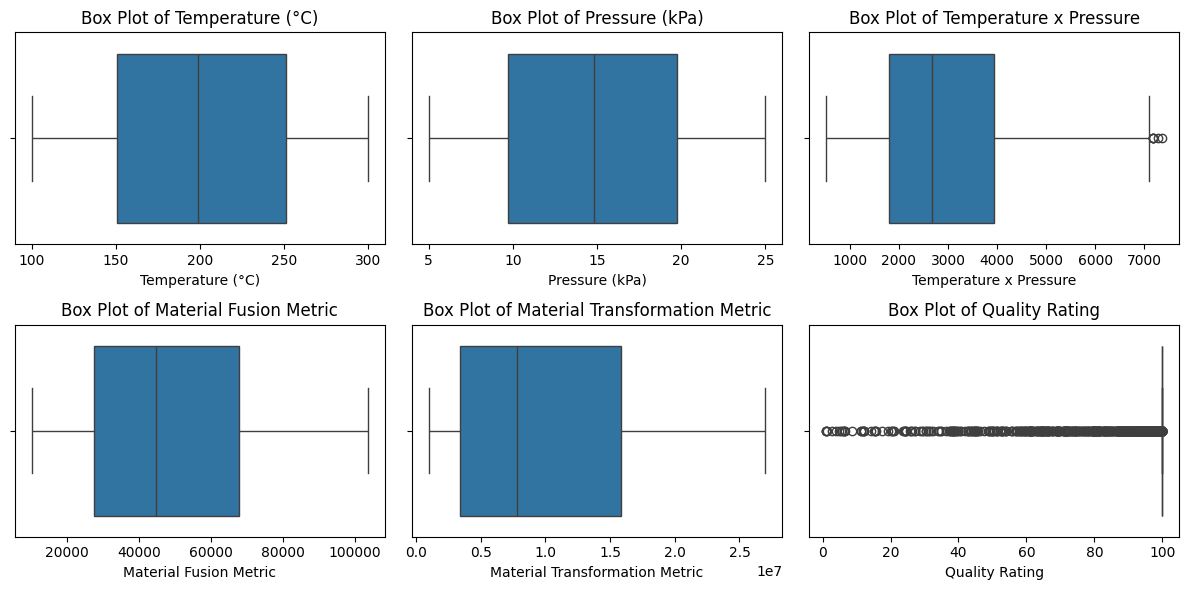

In [11]:
#box plots
plt.figure(figsize=(12, 6))
for i, col in enumerate(numerical_columns):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x=df[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

In [14]:
#allow user to select model based on whether variable-variable relationships are linear or non-linear
#for now, polynomial - test different degree selection
y = df['Quality Rating']
X = df.drop('Quality Rating', axis=1)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize dictionaries to store the best polynomial degree for each column
best_degrees = {}

# Initialize dictionaries to store the MSE values for each degree
mse_values = {}

# Loop through each column and find the best polynomial degree
for column in X.columns:
    best_degree = 1  # Initialize the best degree to 1
    best_mse = float('inf')  # Initialize the best MSE to infinity
    degrees = list(range(1, 30))  # Degrees from 1 to 10
    mse_list = []  # List to store MSE values for each degree
    
    for degree in degrees:
        # Create polynomial features
        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train[[column]])
        X_test_poly = poly.transform(X_test[[column]])
        
        # Fit a linear regression model
        model = LinearRegression()
        model.fit(X_train_poly, y_train)
        
        # Make predictions on the test set
        y_pred = model.predict(X_test_poly)
        
        # Calculate mean squared error (MSE)
        mse = mean_squared_error(y_test, y_pred)
        
        # Append MSE to the list
        mse_list.append(mse)
        
        # Update best_degree if this degree has a lower MSE
        if mse < best_mse:
            best_mse = mse
            best_degree = degree
    
    # Store the best degree for this column in the dictionary
    best_degrees[column] = best_degree
    
    # Store the MSE values for this column in the dictionary
    mse_values[column] = mse_list

In [15]:
mse_list

[135.7569788592151,
 66.38128984602669,
 38.86712912475744,
 22.13317233508307,
 12.207602198778797,
 6.446798951626063,
 3.2163102349932755,
 1.4907087397993368,
 0.6266384003834973,
 0.22979083034173084,
 0.0684724531756428,
 0.014238588009186126,
 0.0013243545454321715,
 5.989655511284725e-28,
 6.399544450320774e-28,
 0.0008142796652712863,
 0.006335993860409169,
 0.022086624662635695,
 0.05386625841905619,
 0.10714338230061743,
 0.18680632917732354,
 0.2970823500291934,
 0.4415310092116795,
 0.6230695729082931,
 0.8440119803562112,
 1.1061134211811765,
 1.4106168200929714,
 1.7582992557145443,
 2.1495171160139535]

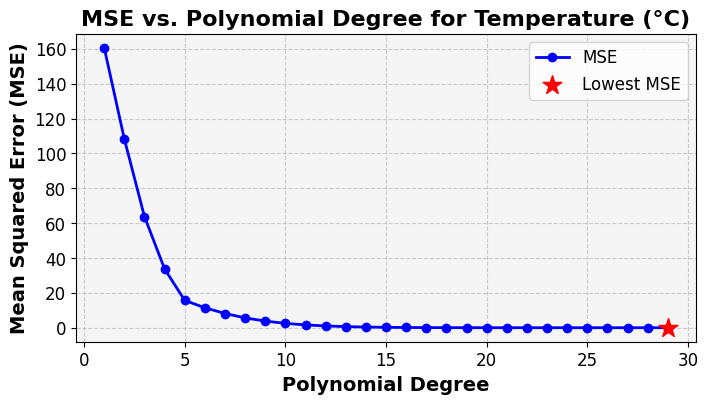

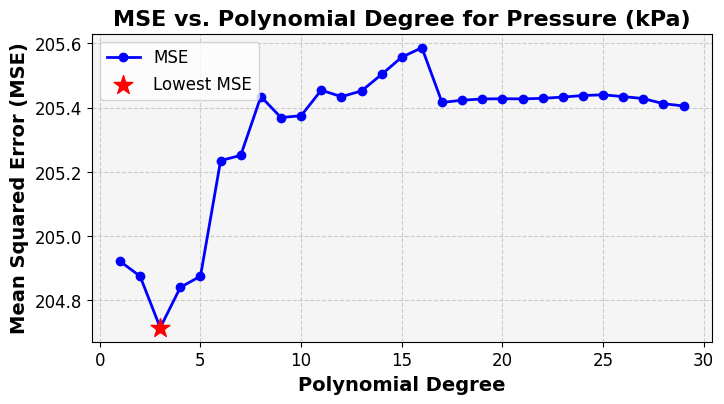

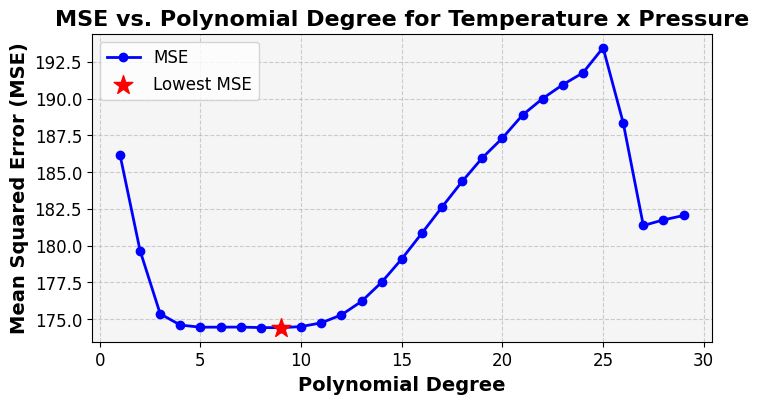

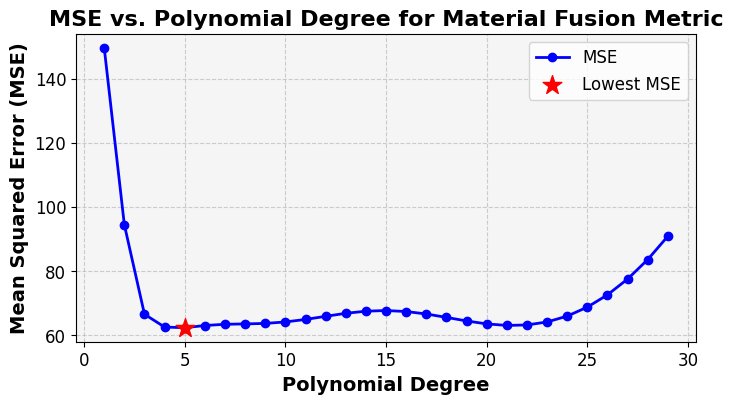

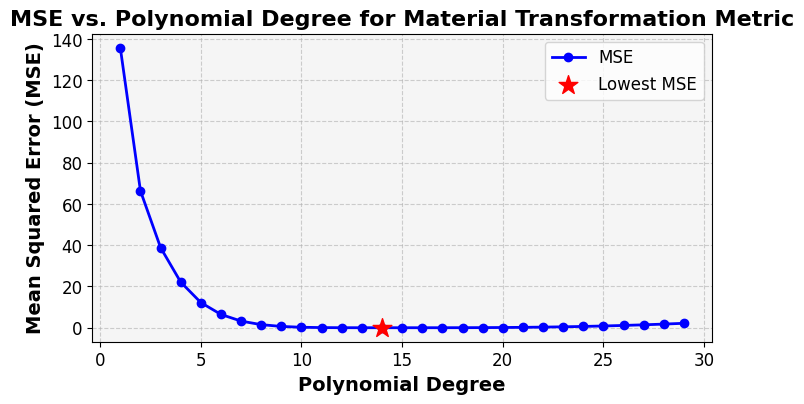

In [16]:
for column in X.columns:
    degrees = list(range(1, 30)) 
    mse_list = mse_values[column]
    
    plt.figure(figsize=(8, 4))
    
    # Plot the MSE values for different polynomial degrees
    plt.plot(degrees, mse_list, marker='o', linestyle='-', color='b', label='MSE', linewidth=2)
    
    # Find the index of the lowest MSE
    lowest_mse_index = np.argmin(mse_list)
    lowest_mse_degree = degrees[lowest_mse_index]
    lowest_mse = mse_list[lowest_mse_index]
    
    # Highlight the lowest MSE point with a red star
    plt.scatter(lowest_mse_degree, lowest_mse, color='red', marker='*', s=200, label='Lowest MSE', zorder=3)
    
    plt.title(f'MSE vs. Polynomial Degree for {column}', fontsize=16, fontweight='bold')
    plt.xlabel('Polynomial Degree', fontsize=14, fontweight='bold')
    plt.ylabel('Mean Squared Error (MSE)', fontsize=14, fontweight='bold')
    
    plt.legend(fontsize=12)
    
    plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    ax = plt.gca()
    ax.set_facecolor('#F5F5F5')
    plt.show()

In [17]:
#extract data and reshape into NumPy arrays
df_train = pd.concat([y_train, X_train], axis=1, sort=True)
Temperature_train = df_train["Temperature (°C)"].values.reshape(-1,1)
Pressure_train = df_train["Pressure (kPa)"].values.reshape(-1,1)
TempPress_train = df_train["Temperature x Pressure"].values.reshape(-1,1)
Fusion_train = df_train["Material Fusion Metric"].values.reshape(-1,1)
Transformation_train = df_train["Material Transformation Metric"].values.reshape(-1,1)

In [18]:
df_test = pd.concat([y_test, X_test], axis=1, sort=True)
Temperature_test = df_test["Temperature (°C)"].values.reshape(-1, 1)
Pressure_test = df_test["Pressure (kPa)"].values.reshape(-1, 1)
TempPress_test = df_test["Temperature x Pressure"].values.reshape(-1, 1)
Fusion_test = df_test["Material Fusion Metric"].values.reshape(-1, 1)
Transformation_test = df_test["Material Transformation Metric"].values.reshape(-1, 1)

In [19]:
poly_features = PolynomialFeatures(degree =  13) #best_degrees["Temperature (°C)"])
Temperature_train = poly_features.fit_transform(Temperature_train)
Temperature_test  = poly_features.fit_transform(Temperature_test)

poly_features = PolynomialFeatures(degree =  best_degrees["Pressure (kPa)"])
Pressure_train = poly_features.fit_transform(Pressure_train)
Pressure_test  = poly_features.fit_transform(Pressure_test)

poly_features = PolynomialFeatures(degree = 5)#best_degrees['Temperature x Pressure'])
TempPress_train = poly_features.fit_transform(TempPress_train)
TempPress_test  = poly_features.fit_transform(TempPress_test)

poly_features = PolynomialFeatures(degree  = 5)# best_degrees[ 'Material Fusion Metric'])
Fusion_train= poly_features.fit_transform(Fusion_train)
Fusion_test  = poly_features.fit_transform(Fusion_test)

poly_features = PolynomialFeatures(degree  = 10)# best_degrees["Material Transformation Metric"])
Transformation_train = poly_features.fit_transform(Transformation_train)
Transformation_test  = poly_features.fit_transform(Transformation_test)

In [20]:
#create new train-test set
X_train1 = np.concatenate((Temperature_train,Pressure_train,TempPress_train,Fusion_train,Transformation_train),axis =1)
X_test1 = np.concatenate((Temperature_test, Pressure_test, TempPress_test, Fusion_test, Transformation_test), axis=1)

In [21]:
# Assuming you have a DataFrame X_train

# Cartesian product between 'Pressure (kPa)' and 'Temperature (°C)'
X_train["int1"] = X_train["Pressure (kPa)"].mul(X_train["Temperature (°C)"])

# Cartesian product between 'Temperature x Pressure' and 'Temperature (°C)'
X_train["int2"] = X_train["Temperature x Pressure"].mul(X_train["Temperature (°C)"])

# Cartesian product between 'Material Fusion Metric' and 'Temperature (°C)'
X_train["int3"] = X_train["Material Fusion Metric"].mul(X_train["Temperature (°C)"])

# Cartesian product between 'Material Transformation Metric' and 'Pressure (kPa)'
X_train["int4"] = X_train["Material Transformation Metric"].mul(X_train["Pressure (kPa)"])

# Cartesian product between 'Temperature x Pressure' and 'Pressure (kPa)'
X_train["int5"] = X_train["Temperature x Pressure"].mul(X_train["Pressure (kPa)"])

# Cartesian product between 'Material Fusion Metric' and 'Pressure (kPa)'
X_train["int6"] = X_train["Material Fusion Metric"].mul(X_train["Pressure (kPa)"])

# Cartesian product between 'Material Transformation Metric' and 'Temperature x Pressure'
X_train["int7"] = X_train["Material Transformation Metric"].mul(X_train["Temperature x Pressure"])

# Cartesian product between 'Material Fusion Metric' and 'Material Transformation Metric'
X_train["int8"] = X_train["Material Fusion Metric"].mul(X_train["Material Transformation Metric"])

# Additional Cartesian product pairs
X_train["int9"] = X_train["Pressure (kPa)"].mul(X_train["Material Fusion Metric"])
X_train["int10"] = X_train["Pressure (kPa)"].mul(X_train["Material Transformation Metric"])
X_train["int11"] = X_train["Temperature x Pressure"].mul(X_train["Material Fusion Metric"])
X_train["int12"] = X_train["Temperature x Pressure"].mul(X_train["Material Transformation Metric"])
X_train["int13"] = X_train["Material Fusion Metric"].mul(X_train["Material Fusion Metric"])
X_train["int14"] = X_train["Material Transformation Metric"].mul(X_train["Material Transformation Metric"])

In [22]:
# Cartesian product between 'Pressure (kPa)' and 'Temperature (°C)'
X_test["int1"] = X_test["Pressure (kPa)"].mul(X_test["Temperature (°C)"])

# Cartesian product between 'Temperature x Pressure' and 'Temperature (°C)'
X_test["int2"] = X_test["Temperature x Pressure"].mul(X_test["Temperature (°C)"])

# Cartesian product between 'Material Fusion Metric' and 'Temperature (°C)'
X_test["int3"] = X_test["Material Fusion Metric"].mul(X_test["Temperature (°C)"])

# Cartesian product between 'Material Transformation Metric' and 'Pressure (kPa)'
X_test["int4"] = X_test["Material Transformation Metric"].mul(X_test["Pressure (kPa)"])

# Cartesian product between 'Temperature x Pressure' and 'Pressure (kPa)'
X_test["int5"] = X_test["Temperature x Pressure"].mul(X_test["Pressure (kPa)"])

# Cartesian product between 'Material Fusion Metric' and 'Pressure (kPa)'
X_test["int6"] = X_test["Material Fusion Metric"].mul(X_test["Pressure (kPa)"])

# Cartesian product between 'Material Transformation Metric' and 'Temperature x Pressure'
X_test["int7"] = X_test["Material Transformation Metric"].mul(X_test["Temperature x Pressure"])

# Cartesian product between 'Material Fusion Metric' and 'Material Transformation Metric'
X_test["int8"] = X_test["Material Fusion Metric"].mul(X_test["Material Transformation Metric"])

# Additional Cartesian product pairs
X_test["int9"] = X_test["Pressure (kPa)"].mul(X_test["Material Fusion Metric"])
X_test["int10"] = X_test["Pressure (kPa)"].mul(X_test["Material Transformation Metric"])
X_test["int11"] = X_test["Temperature x Pressure"].mul(X_test["Material Fusion Metric"])
X_test["int12"] = X_test["Temperature x Pressure"].mul(X_test["Material Transformation Metric"])
X_test["int13"] = X_test["Material Fusion Metric"].mul(X_test["Material Fusion Metric"])
X_test["int14"] = X_test["Material Transformation Metric"].mul(X_test["Material Transformation Metric"])

In [23]:
#column selection
X_train2 = np.array(X_train[['int1','int2','int3','int4','int5','int6','int7','int8','int9','int10','int11','int12','int13','int14']])
X_test2 = np.array(X_test[['int1','int2','int3','int4','int5','int6','int7','int8','int9','int10','int11','int12','int13','int14']])

In [24]:
X_train1 = np.concatenate ((X_train1, X_train2), axis = 1)
X_test1 = np.concatenate ((X_test1, X_test2), axis = 1)

In [25]:
#create linear model for comparison
poly_reg = LinearRegression()
poly_reg.fit(X_train1, y_train)

LinearRegression()

In [27]:
score = poly_reg.score(X_test1, y_test)
score

-0.0016491787398942304

In [29]:
score = poly_reg.score(X_train1, y_train)
score

0.0007980926119611764

In [30]:
y_pred_train = poly_reg.predict(X_train1)

for i, (real_value, prediction) in enumerate(zip(y_train.iloc[:10], y_pred_train[:10])):
    print(f"Sample {i + 1} - Real Value: {real_value}, Predicted Value: {prediction}")

Sample 1 - Real Value: 99.9998950832658, Predicted Value: 96.17520448350191
Sample 2 - Real Value: 99.99999996545394, Predicted Value: 96.2188159875466
Sample 3 - Real Value: 99.99999999972384, Predicted Value: 96.17819223267455
Sample 4 - Real Value: 100.0, Predicted Value: 96.17509728326546
Sample 5 - Real Value: 100.0, Predicted Value: 96.1740794147056
Sample 6 - Real Value: 46.3670249698838, Predicted Value: 96.18483234680298
Sample 7 - Real Value: 99.9981213046946, Predicted Value: 96.96066189652875
Sample 8 - Real Value: 99.9994029171498, Predicted Value: 96.17404922591896
Sample 9 - Real Value: 100.0, Predicted Value: 96.35577430613155
Sample 10 - Real Value: 99.99999997078464, Predicted Value: 96.1747518135869


In [31]:
y_pred_test = poly_reg.predict(X_test1)

for i, (real_value, prediction) in enumerate(zip(y_test.iloc[:10], y_pred_test[:10])):
    print(f"Sample {i + 1} - Real Value: {real_value}, Predicted Value: {prediction}")

Sample 1 - Real Value: 4.052686484307197, Predicted Value: 96.17410035877887
Sample 2 - Real Value: 98.8730359715154, Predicted Value: 97.41499550559857
Sample 3 - Real Value: 96.91493256400273, Predicted Value: 96.17588976563071
Sample 4 - Real Value: 99.9515431703238, Predicted Value: 96.17403554651067
Sample 5 - Real Value: 99.99999939463342, Predicted Value: 96.52605182347811
Sample 6 - Real Value: 99.99999801897562, Predicted Value: 96.17403554940546
Sample 7 - Real Value: 99.9999414424484, Predicted Value: 96.17406953082164
Sample 8 - Real Value: 99.99962261607838, Predicted Value: 96.17403584712304
Sample 9 - Real Value: 100.0, Predicted Value: 96.17414352997385
Sample 10 - Real Value: 59.01936688952299, Predicted Value: 96.17590772031271


In [32]:
#create polynomial model
rmse= []
degrees = np.arange(1,5)
min_rmse , min_value = 1e10, 0

for degree in degrees:
    poly_features = PolynomialFeatures(degree=degree)
    X_poly_train = poly_features.fit_transform(X_train)
    
    # Create and train a linear regression model
    model = LinearRegression()
    model.fit(X_poly_train, y_train)
    
    X_poly_test = poly_features.fit_transform(X_test)

    # Make predictions
    y_pred = model.predict(X_poly_test)
    
    # Calculate RMSE
    mse = mean_squared_error(y_test, y_pred)
    current_rmse = np.sqrt(mse)
    
    # Store RMSE values
    rmse.append(current_rmse)
    
    # Check if this is the model with the lowest RMSE
    if current_rmse < min_rmse:
        min_rmse = current_rmse
        min_degree = degree

print("RMSE values for polynomial degrees 2 to 5:", rmse)
print("Minimum RMSE:", min_rmse)
print("Degree with minimum RMSE:", min_degree)

RMSE values for polynomial degrees 2 to 5: [5.285541833839329, 1.3865899322479243, 0.5482198921884396, 0.12621911265894925]
Minimum RMSE: 0.12621911265894925
Degree with minimum RMSE: 4


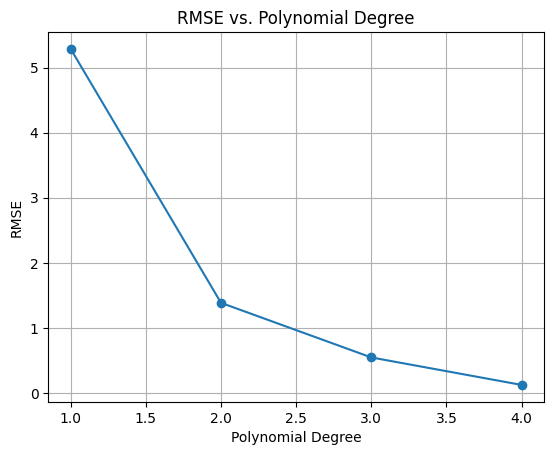

In [33]:
plt.plot(degrees, rmse, marker='o')
plt.title('RMSE vs. Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

In [34]:
poly_degree = PolynomialFeatures(degree = 2)
X_train_pol = poly_degree.fit_transform(X_train)
X_test_pol = poly_degree.transform(X_test)

In [37]:
PR = LinearRegression()
PR.fit(X_train_pol, y_train)
y_pred_PR = PR.predict(X_test_pol)
mse_PR = mean_squared_error(y_test, y_pred_PR)# Calculate the Mean Squared Error (MSE)
# Print the scores for Polynomial Regression
print("Polynomial")
print(mse_PR)
print(PR.score(X_test_pol, y_test))
print(PR.score(X_train_pol, y_train))

LR = LinearRegression()
LR.fit(X_train, y_train)
y_pred_LR = LR.predict(X_test)
mse_LR = mean_squared_error(y_test, y_pred_LR)# Calculate the Mean Squared Error (MSE)
# Print the scores for Linear Regression
print("Linear")
print(mse_LR)
print(LR.score(X_test, y_test))
print(LR.score(X_train, y_train))


Polynomial
1.922631640211303
0.9905822879157178
0.9894403796294655
Linear
27.80506875739604
0.8638011949017723
0.8606855945531743


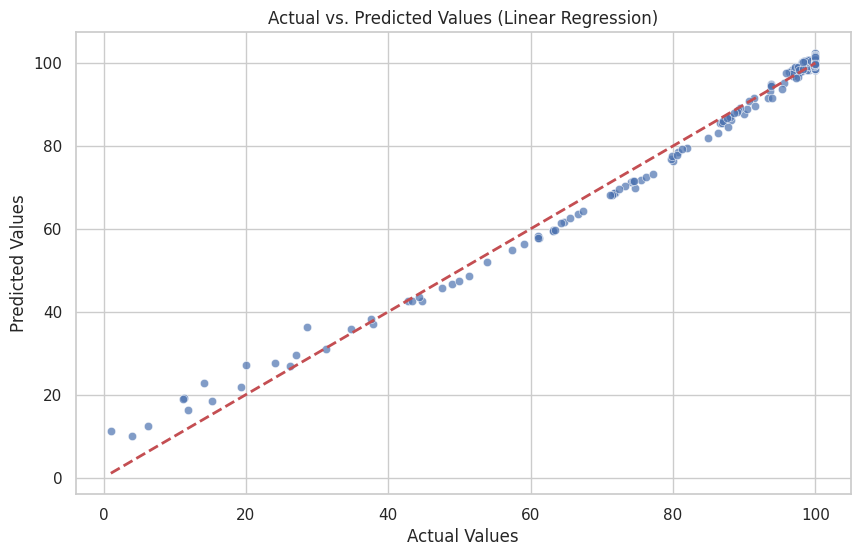

In [38]:
# Create a scatterplot of actual vs. predicted values
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.scatterplot(x=y_test, y=y_pred_PR, color='b', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='r', linewidth=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values (Linear Regression)")
plt.show()

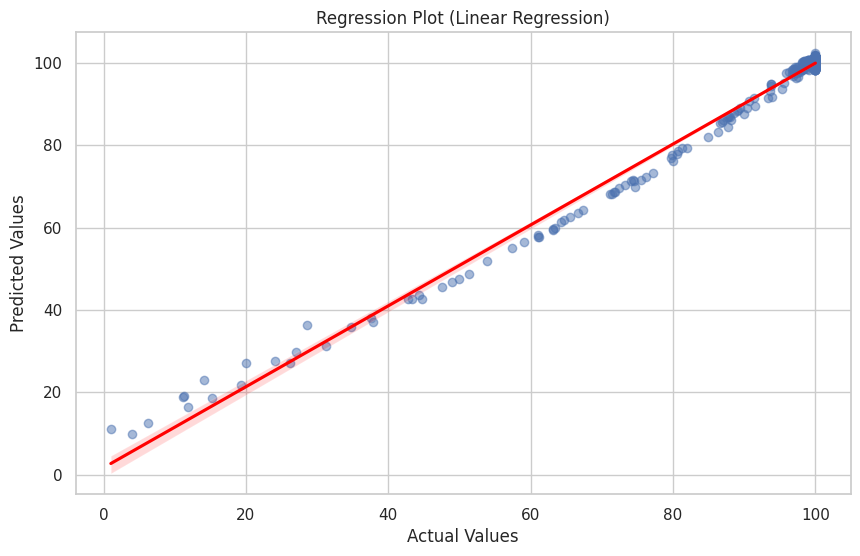

In [39]:
# Create a regression plot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.regplot(x=y_test, y=y_pred_PR, scatter_kws={"alpha":0.5}, line_kws={"color":"red"})
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Regression Plot (Linear Regression)")
plt.show()

Text(0.5, 1.0, 'Residuals vs. Fitted Values')

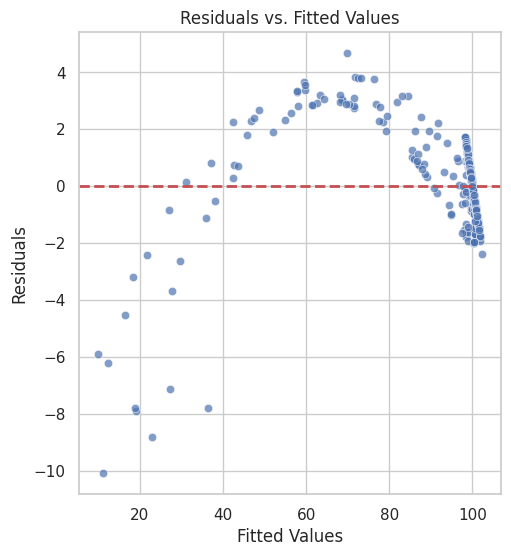

In [40]:
# Create residual plots
plt.figure(figsize=(12, 6))
# Residuals vs. Fitted Values
plt.subplot(1, 2, 1)
sns.set(style="whitegrid")
sns.scatterplot(x=y_pred_PR, y=y_test-y_pred_PR, color='b', alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values")

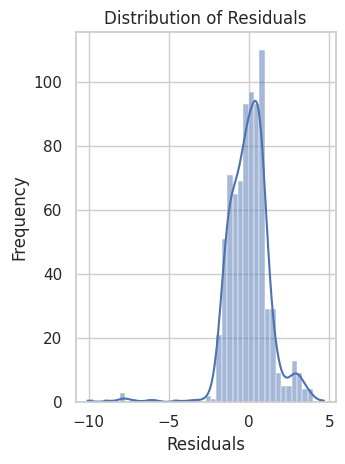

In [41]:
# Distribution of Residuals
plt.subplot(1, 2, 2)
sns.set(style="whitegrid")
sns.histplot(y_test - y_pred_PR, kde=True, color='b')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.tight_layout()
plt.show()

In [42]:
#create instance of LpProblem - choose maximization obviously
#model = LpProblem(name="small-problem", sense=LpMaximize)
#create constraints?

In [54]:

def objective(v):
    return poly_reg.predict(np.array([v]))[0]

def objective_max(v):
    return -poly_reg.predict(np.array([v]))[0]

In [56]:
#set constraints ("boundaries") of each feature
#poly_reg has 55 (?)
b = [1,10]
bounds = [b] * 55
bounds

[[1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10],
 [1, 10]]

In [57]:
#set constraints ("boundaries") of each feature
result = dual_annealing(objective, bounds, maxiter=100)
print(f"Status: {result['message']}")
print(f"Total Evaluations: {result['nfev']}")
print(f"Minimum reached: {result['fun']}")
print(f"Solution vector: {result['x']}")

Status: ['Maximum number of iteration reached']
Total Evaluations: 11057
Minimum reached: 96.17403554638737
Solution vector: [4.71757459 4.93363644 4.72281199 2.59960221 6.46172609 3.9405416
 2.36731175 9.4430351  1.73965757 9.13060914 7.52745189 3.70940352
 5.93687152 4.07477944 3.70393842 7.04906692 2.07022458 2.15644689
 6.71203396 8.80541482 8.25136286 8.78502665 7.36824856 5.07330888
 3.38267569 9.61953031 8.25525248 9.88294578 6.43057513 4.09721851
 6.07756619 5.07085953 1.82860768 6.53891054 4.2404095  6.49030906
 1.53405428 2.44680184 7.15128784 7.73093898 7.98643302 9.1239208
 5.83392861 5.48514443 1.27954404 8.28292314 1.62335835 6.26300558
 1.09323827 3.5602344  4.38055124 5.41305386 6.20266802 3.44931795
 8.38122786]
